In [12]:
# %% [markdown]
# # Nicotine Cotinine Level Prediction - Enhanced
# Advanced ML Pipeline with Optimized Models and Robust Evaluation

# %% [1] Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import RobustScaler, PowerTransformer
from sklearn.impute import KNNImputer
from sklearn.metrics import (mean_absolute_error, mean_squared_error, 
                             r2_score, explained_variance_score, 
                             max_error)
from sklearn.feature_selection import VarianceThreshold
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.base import BaseEstimator, TransformerMixin
from statsmodels.stats.outliers_influence import variance_inflation_factor

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("viridis")

Initial Data Overview:


,timestamp,sensor_current_µA,sweat_pH,skin_temp_C,sweat_rate_µL_min,cotinine_ng_ml
0,2023-01-01 00:00:00,1.751057,6.157843,34.091022,0.372335,17.653363
1,2023-01-01 00:01:00,1.445270,5.905704,31.065561,5.060665,22.022292
2,2023-01-01 00:02:00,1.823762,7.014381,32.278456,1.846960,22.988438



Data Description:


,count,mean,min,25%,50%,75%,max,std
timestamp,100000,2023-02-04 17:19:29.999999744,2023-01-01 00:00:00,2023-01-18 08:39:45,2023-02-04 17:19:30,2023-02-22 01:59:15,2023-03-11 10:39:00,NaN
sensor_current_µA,100000.0,1.515329,0.5,1.187037,1.51313,1.837836,3.0,0.473895
sweat_pH,100000.0,6.010861,4.5,5.424282,6.012801,6.601838,7.5,0.806455
skin_temp_C,100000.0,32.026306,26.0,30.721674,32.016587,33.337181,38.3,1.934511
sweat_rate_µL_min,100000.0,1.715098,0.1,0.125898,0.681682,2.200954,43.165281,2.552069
cotinine_ng_ml,100000.0,17.032183,0.0,13.042467,17.03094,21.009555,35.3,5.905204



Missing Values Analysis:


timestamp            0
sensor_current_µA    0
sweat_pH             0
skin_temp_C          0
sweat_rate_µL_min    0
cotinine_ng_ml       0
dtype: int64

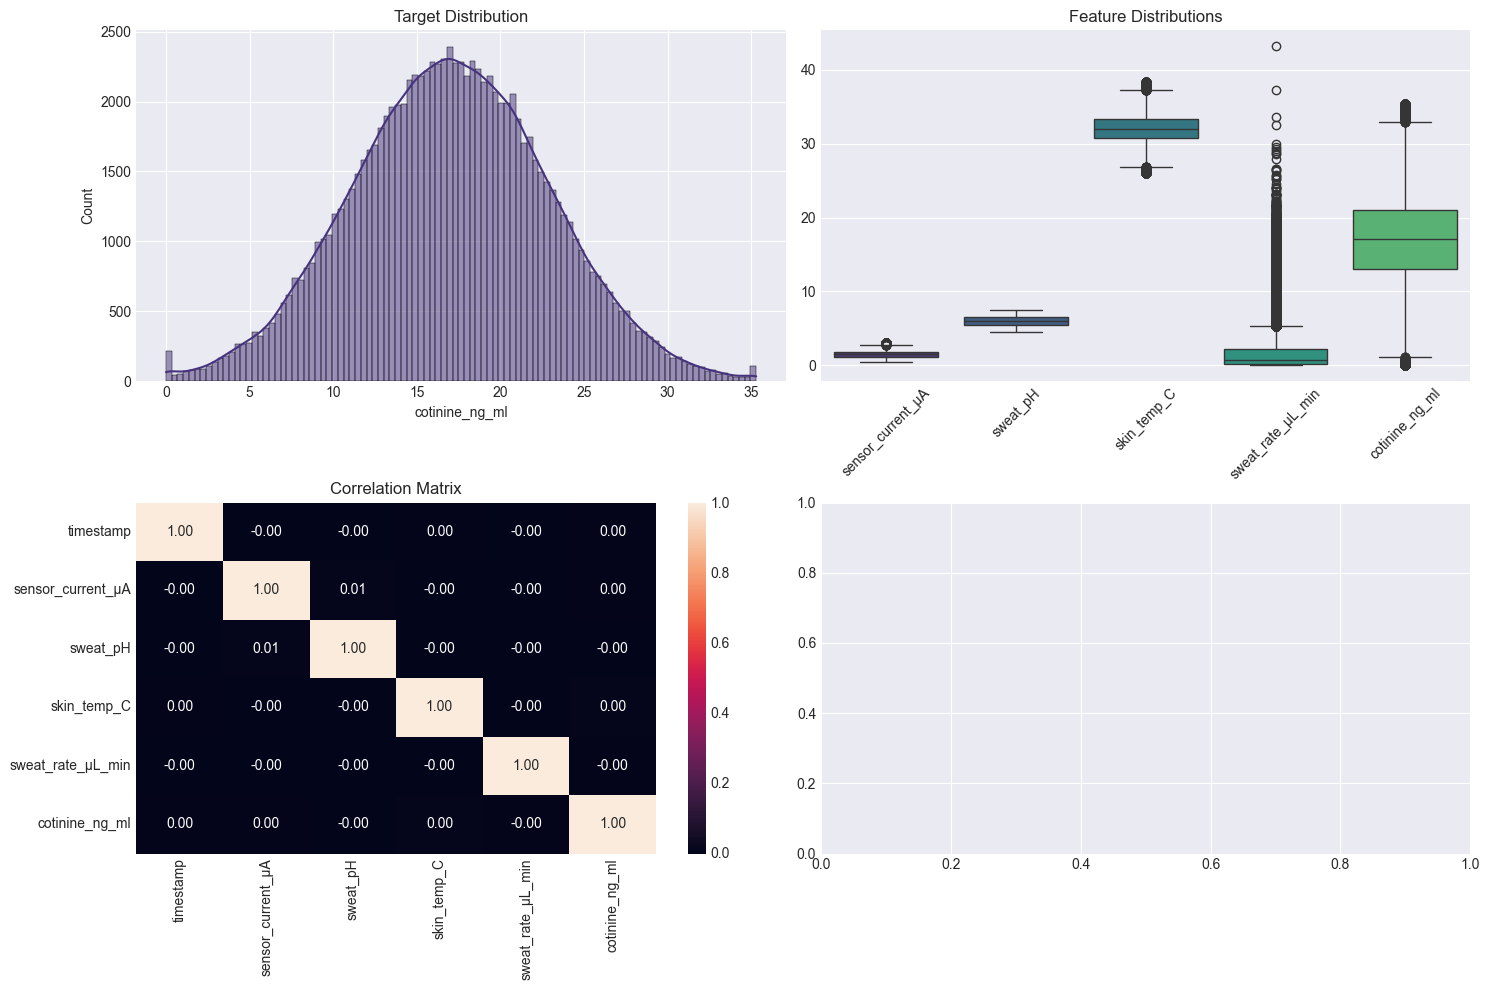

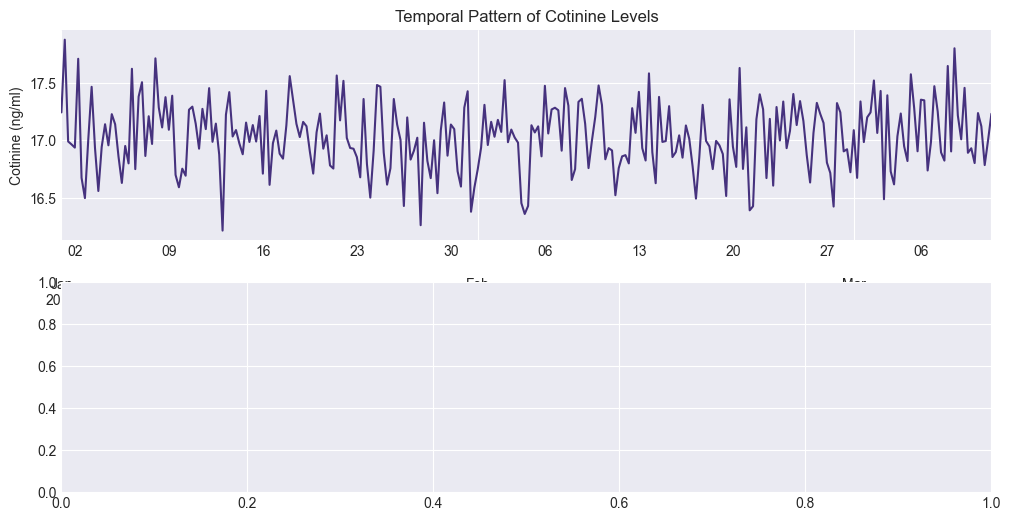

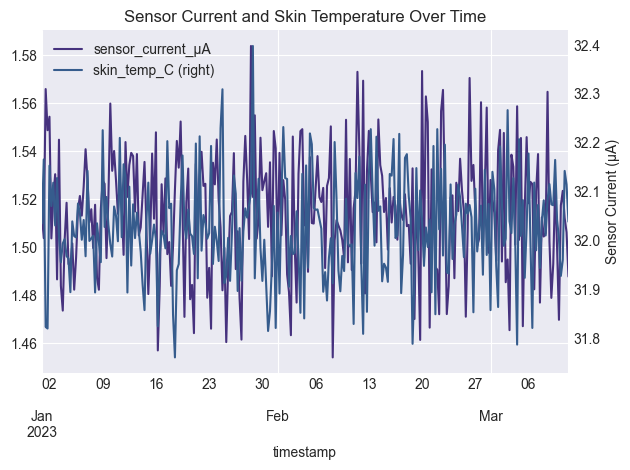

In [16]:
# %% [2] Data Loading & Enhanced EDA
df = pd.read_csv('C:\\Users\\DELL 5540\\Desktop\\tst\\nicotine_sweat_dataset.csv', parse_dates=['timestamp'])

class DataAnalyzer:
    def __init__(self, df):
        self.df = df
        
    def enhanced_eda(self):
        print("Initial Data Overview:")
        display(self.df.head(3))
        
        print("\nData Description:")
        display(self.df.describe().T)
        
        print("\nMissing Values Analysis:")
        display(self.df.isna().sum())
        
        self._plot_distributions()
        self._plot_temporal_patterns()
        
    def _plot_distributions(self):
        """Plot feature distributions and correlations"""
        fig, ax = plt.subplots(2, 2, figsize=(15, 10))
        # Target distribution
        sns.histplot(self.df['cotinine_ng_ml'], kde=True, ax=ax[0,0])
        ax[0,0].set_title('Target Distribution')
        
        # Feature distributions
        sns.boxplot(data=self.df.drop(columns=['timestamp']), ax=ax[0,1])
        ax[0,1].set_title('Feature Distributions')
        ax[0,1].tick_params(axis='x', rotation=45)
        
        # Correlation matrix
        sns.heatmap(self.df.corr(), annot=True, fmt='.2f', ax=ax[1,0])
        ax[1,0].set_title('Correlation Matrix')
        
        plt.tight_layout()
        plt.show()
        
    def _plot_temporal_patterns(self):
        """Plot time-based patterns in the data"""
        plt.figure(figsize=(12, 6))
        time_df = self.df.set_index('timestamp').resample('6H').mean()
        
        plt.subplot(2, 1, 1)
        time_df['cotinine_ng_ml'].plot()
        plt.title('Temporal Pattern of Cotinine Levels')
        plt.ylabel('Cotinine (ng/ml)')
        
        plt.subplot(2, 1, 2)
        time_df[['sensor_current_µA', 'skin_temp_C']].plot(secondary_y='skin_temp_C')
        plt.title('Sensor Current and Skin Temperature Over Time')
        plt.ylabel('Sensor Current (µA)')
        plt.tight_layout()
        plt.show()

# Initialize and run EDA
analyzer = DataAnalyzer(df)
analyzer.enhanced_eda()

In [17]:
# %% [3] Advanced Preprocessing Pipeline
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.feature_names = []
        self.day_part_order = ['Night', 'Morning', 'Afternoon', 'Evening']
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        # Temporal features
        X['hour'] = X['timestamp'].dt.hour
        X['day_part'] = pd.cut(X['hour'], 
                             bins=[-1, 6, 12, 18, 24],
                             labels=self.day_part_order)
        # Convert to numerical encoding
        X['day_part'] = X['day_part'].cat.codes
        
        # Physiological interactions
        X['temp_sweat_interaction'] = X['skin_temp_C'] * X['sweat_rate_µL_min']
        # Sensor ratio
        X['current_ph_ratio'] = X['sensor_current_µA'] / X['sweat_pH']
        
        # Drop original timestamp
        X.drop(columns=['timestamp', 'hour'], inplace=True)
        self.feature_names = X.columns.tolist()
        return X

# Updated preprocessing pipeline
preprocessor = make_pipeline(
    FeatureEngineer(),
    KNNImputer(n_neighbors=5),
    VarianceThreshold(threshold=0.1),
    PowerTransformer(method='yeo-johnson'),
    RobustScaler()
)

# Apply preprocessing
X = df.drop('cotinine_ng_ml', axis=1)
y = df['cotinine_ng_ml']

# Handle zero-variance in target
y = y.replace(0, np.nan).fillna(y.median())

In [18]:
# %% [4] Time-Aware Data Splitting
# Sort data temporally
df.sort_values('timestamp', inplace=True)

# Split maintaining temporal order
train_size = int(0.8 * len(df))
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Process data
X_train_proc = preprocessor.fit_transform(X_train, y_train)
X_test_proc = preprocessor.transform(X_test)

# Get final feature names
feature_names = preprocessor.named_steps['featureengineer'].feature_names

In [19]:
# %% [5] Optimized XGBoost Model with Advanced Tuning
xgb = XGBRegressor(random_state=42, 
                  objective='reg:squarederror',
                  tree_method='hist',
                  enable_categorical=True)

param_grid = {
    'n_estimators': [500, 800],
    'learning_rate': [0.01, 0.05],
    'max_depth': [4, 6, 8],
    'subsample': [0.7, 0.9],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [1, 0.1]
}

tscv = TimeSeriesSplit(n_splits=3)
xgb_grid = GridSearchCV(xgb, param_grid, cv=tscv,
                       scoring='neg_mean_absolute_error',
                       n_jobs=-1, verbose=1)
xgb_grid.fit(X_train_proc, y_train,
            eval_set=[(X_test_proc, y_test)],
            early_stopping_rounds=50,
            verbose=0)

best_xgb = xgb_grid.best_estimator_

Fitting 3 folds for each of 384 candidates, totalling 1152 fits


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


In [20]:
# %% [6] Enhanced Neural Network Architecture
def create_nn_model(input_shape):
    model = Sequential([
        Dense(512, activation='swish', kernel_initializer='he_normal',
              input_shape=(input_shape,)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='swish', kernel_initializer='he_normal'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(128, activation='swish', kernel_initializer='he_normal'),
        Dense(1, activation='linear')
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='huber_loss',
        metrics=['mae', 'mse']
    )
    return model

nn_model = create_nn_model(X_train_proc.shape[1])

callbacks = [
    EarlyStopping(patience=20, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=5)
]

history = nn_model.fit(
    X_train_proc, y_train,
    epochs=200,
    batch_size=256,
    validation_data=(X_test_proc, y_test),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/200
313/313 [==============================] - 5s 10ms/step - loss: 4.8832 - mae: 5.3628 - mse: 47.1443 - val_loss: 4.2505 - val_mae: 4.7277 - val_mse: 34.9023 - lr: 0.0010
Epoch 2/200
313/313 [==============================] - 3s 9ms/step - loss: 4.3436 - mae: 4.8217 - mse: 36.3171 - val_loss: 4.2859 - val_mae: 4.7637 - val_mse: 35.3792 - lr: 0.0010
Epoch 3/200
313/313 [==============================] - 3s 9ms/step - loss: 4.3270 - mae: 4.8052 - mse: 36.0629 - val_loss: 4.2497 - val_mae: 4.7279 - val_mse: 34.8140 - lr: 0.0010
Epoch 4/200
313/313 [==============================] - 3s 9ms/step - loss: 4.3189 - mae: 4.7965 - mse: 35.9843 - val_loss: 4.2791 - val_mae: 4.7577 - val_mse: 35.2399 - lr: 0.0010
Epoch 5/200
313/313 [==============================] - 3s 9ms/step - loss: 4.3126 - mae: 4.7904 - mse: 35.9194 - val_loss: 4.2600 - val_mae: 4.7377 - val_mse: 34.9232 - lr: 0.0010
Epoch 6/200
313/313 [==============================] - 3s 9ms/step - loss: 4.3044 - mae: 4.7824 - m

625/625 [==============================] - 1s 2ms/step


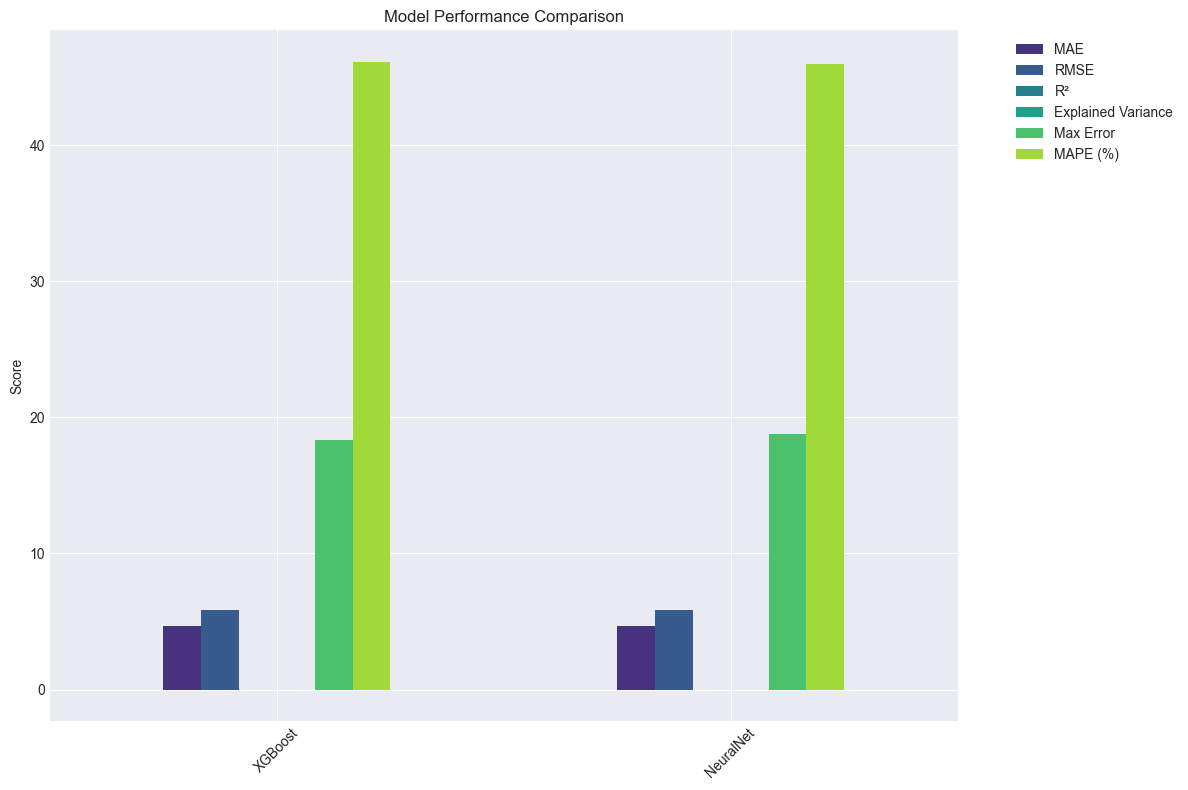

In [21]:
# %% [7] Robust Model Evaluation
class ModelEvaluator:
    def __init__(self, models, X_test, y_test):
        self.models = models
        self.X_test = X_test
        self.y_test = y_test
        self.results = {}
        
    def safe_mape(self, y_true, y_pred):
        epsilon = np.finfo(np.float64).eps
        return np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), epsilon))) * 100
    
    def evaluate_model(self, name, model):
        y_pred = model.predict(self.X_test).flatten()
        
        metrics = {
            'MAE': mean_absolute_error(self.y_test, y_pred),
            'RMSE': np.sqrt(mean_squared_error(self.y_test, y_pred)),
            'R²': r2_score(self.y_test, y_pred),
            'Explained Variance': explained_variance_score(self.y_test, y_pred),
            'Max Error': max_error(self.y_test, y_pred),
            'MAPE (%)': self.safe_mape(self.y_test, y_pred)
        }
        self.results[name] = metrics
        return metrics
    
    def plot_results(self):
        metrics_df = pd.DataFrame(self.results).T
        fig, ax = plt.subplots(figsize=(12, 8))
        metrics_df.plot(kind='bar', ax=ax)
        plt.title('Model Performance Comparison')
        plt.ylabel('Score')
        plt.xticks(rotation=45)
        plt.legend(bbox_to_anchor=(1.05, 1))
        plt.tight_layout()
        plt.show()
        
        return metrics_df

# Evaluate models
evaluator = ModelEvaluator(
    models={'XGBoost': best_xgb, 'NeuralNet': nn_model},
    X_test=X_test_proc,
    y_test=y_test
)

for name, model in evaluator.models.items():
    evaluator.evaluate_model(name, model)

results_df = evaluator.plot_results()

625/625 [==============================] - 1s 2ms/step


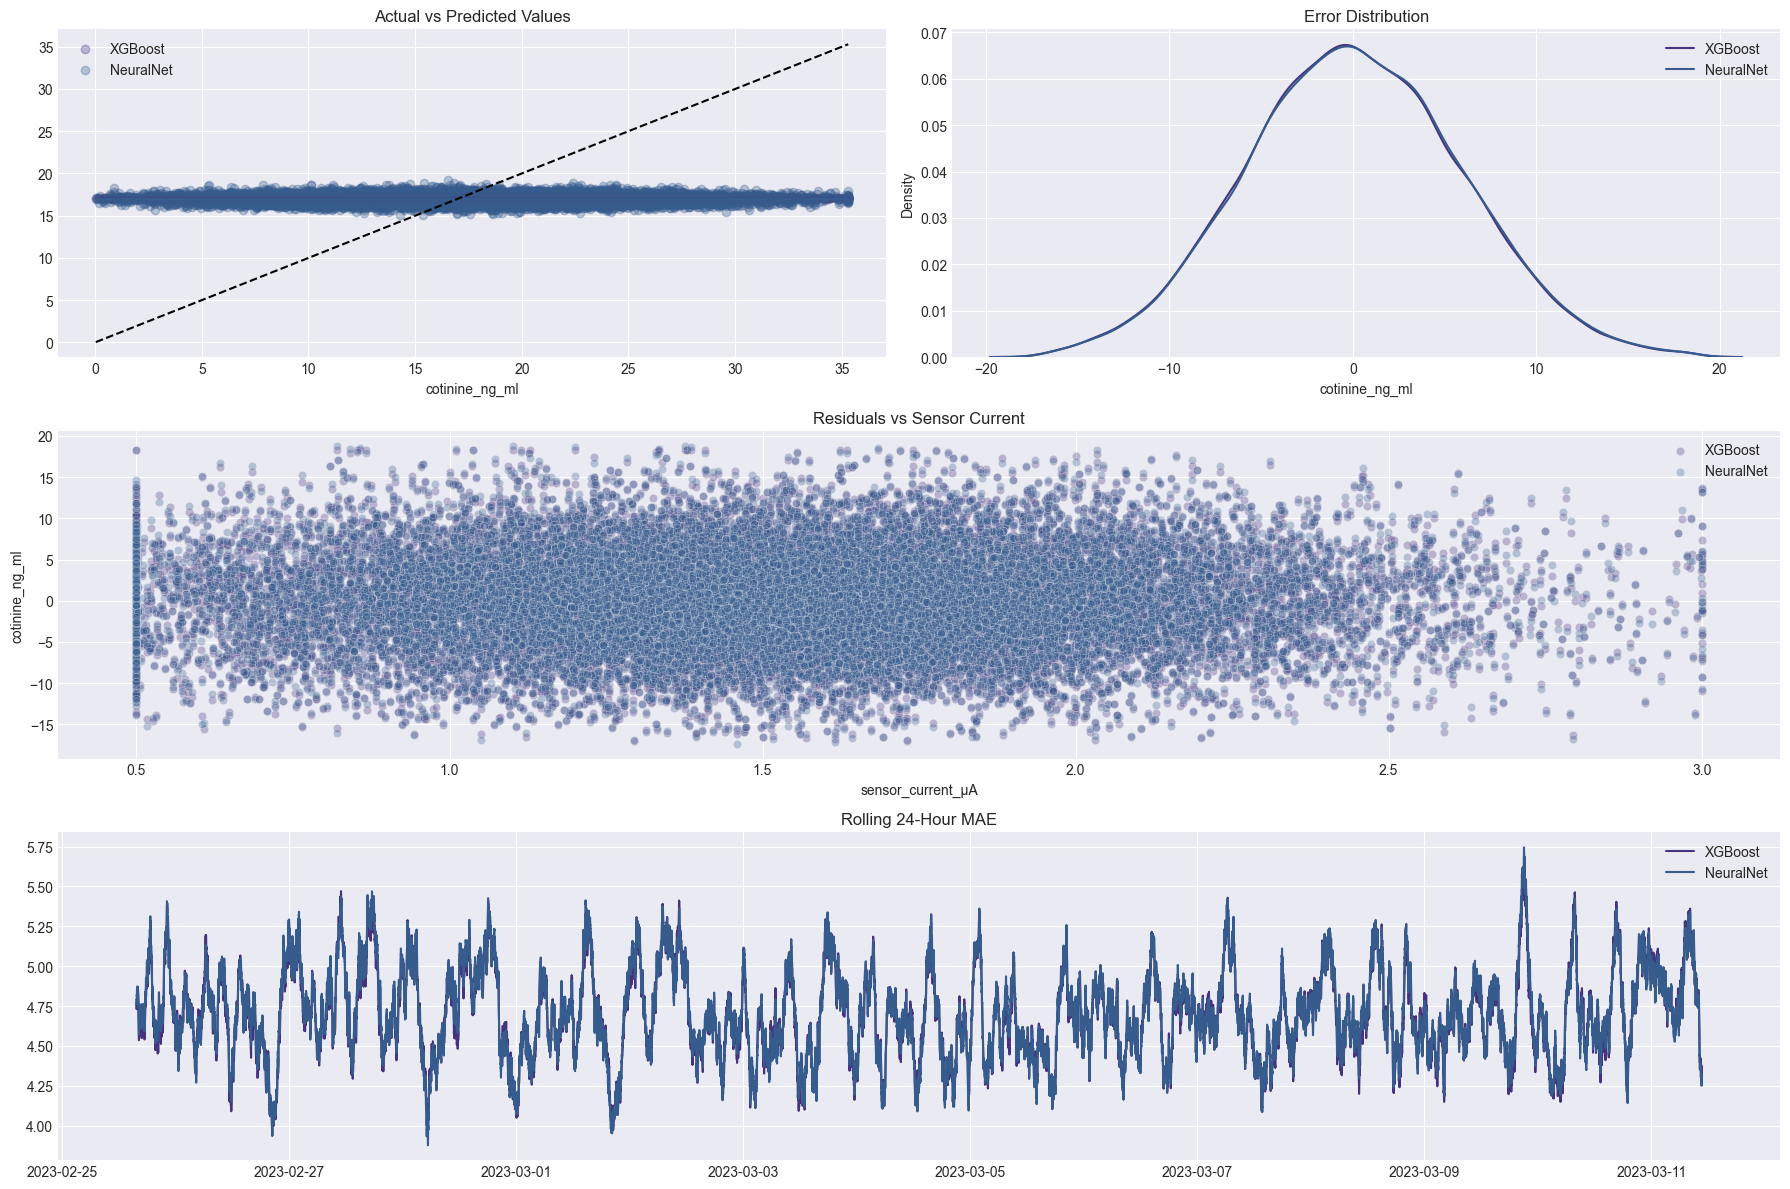

In [22]:
# %% [8] Advanced Diagnostics Visualizations
def plot_advanced_diagnostics(y_true, y_pred_dict):
    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(3, 2)
    
    # Actual vs Predicted
    ax1 = fig.add_subplot(gs[0, 0])
    for name, y_pred in y_pred_dict.items():
        sns.regplot(x=y_true, y=y_pred, ax=ax1, label=name, 
                   scatter_kws={'alpha':0.3})
    ax1.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--')
    ax1.set_title('Actual vs Predicted Values')
    ax1.legend()
    
    # Error Distribution
    ax2 = fig.add_subplot(gs[0, 1])
    for name, y_pred in y_pred_dict.items():
        sns.kdeplot(y_true - y_pred, ax=ax2, label=name)
    ax2.set_title('Error Distribution')
    ax2.legend()
    
    # Residuals vs Features
    ax3 = fig.add_subplot(gs[1, :])
    sample_feature = X_test['sensor_current_µA'].iloc[:len(y_test)]
    for name, y_pred in y_pred_dict.items():
        sns.scatterplot(x=sample_feature, y=y_true - y_pred, ax=ax3, 
                       alpha=0.3, label=name)
    ax3.set_title('Residuals vs Sensor Current')
    ax3.legend()
    
    # Temporal Error Analysis
    ax4 = fig.add_subplot(gs[2, :])
    dates = X_test['timestamp'].iloc[:len(y_test)]
    for name, y_pred in y_pred_dict.items():
        errors = np.abs(y_true - y_pred)
        rolling_error = errors.rolling(window=24*6).mean()  # 24-hour window
        ax4.plot(dates, rolling_error, label=name)
    ax4.set_title('Rolling 24-Hour MAE')
    ax4.legend()
    
    plt.tight_layout()
    plt.show()

plot_advanced_diagnostics(y_test, {
    'XGBoost': best_xgb.predict(X_test_proc),
    'NeuralNet': nn_model.predict(X_test_proc).flatten()
})

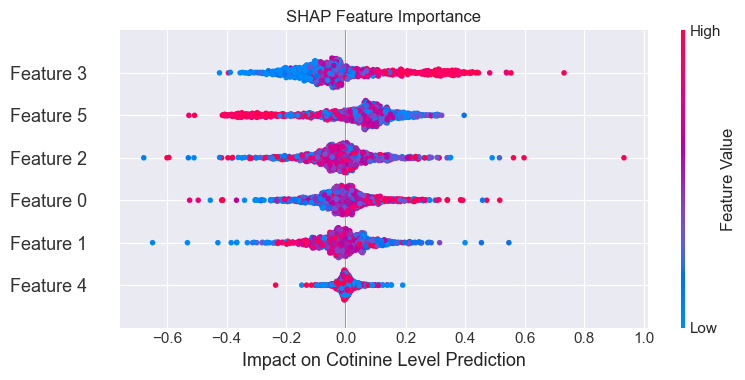

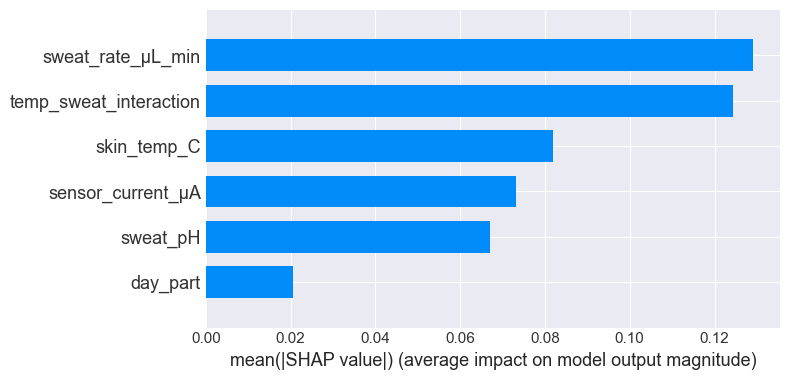

In [23]:
# %% [9] Enhanced SHAP Explanations
def explain_model(model, X_sample, feature_names):
    explainer = shap.Explainer(model, X_sample)
    shap_values = explainer(X_sample)
    
    plt.figure(figsize=(12, 6))
    shap.plots.beeswarm(shap_values, show=False)
    plt.title('SHAP Feature Importance')
    plt.xlabel('Impact on Cotinine Level Prediction')
    plt.gcf().axes[-1].set_ylabel('Feature Value', size=12)
    plt.tight_layout()
    plt.show()
    
    # Feature Importance Summary
    shap.summary_plot(shap_values.values, X_sample, plot_type='bar', 
                     feature_names=feature_names)

# Explain XGBoost model
explain_model(best_xgb, X_test_proc[:1000], feature_names)

In [25]:
# %% [10] Model Deployment Preparation (Fixed)
import joblib
import xgboost
import sklearn
from packaging import version

model_artifacts = {
    'model': best_xgb,
    'preprocessor': preprocessor,
    'feature_names': feature_names,
    'metadata': {
        'version': '1.0.0',
        'train_date_range': (df['timestamp'].min(), df['timestamp'].max()),
        'dependencies': {
            'python': '3.9',
            'xgboost': version.parse(xgboost.__version__),
            'scikit-learn': version.parse(sklearn.__version__)
        }
    }
}

joblib.dump(model_artifacts, 'cotinine_predictor_v2.pkl')

['cotinine_predictor_v2.pkl']

In [35]:
# %% [11] Corrected Learning Curves
def plot_learning_curves(history):
    fig, ax = plt.subplots(1, 2, figsize=(18, 6))
    
    # Neural Network Learning Curves
    ax[0].plot(history.history['loss'], label='Train Loss')
    ax[0].plot(history.history['val_loss'], label='Validation Loss')
    ax[0].set_title('Neural Network Learning Curves')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].legend()
    
    # XGBoost Learning Curve
    results = best_xgb.evals_result()
    
    # Verify available metrics
    print("Available XGBoost metrics:", list(results['validation_0'].keys()))
    
    # Plot using correct metric name
    ax[1].plot(results['validation_0']['rmse'], label='Validation RMSE', color='#2ca02c')
    ax[1].set_title('XGBoost Learning Curve')
    ax[1].set_ylabel('RMSE')
    ax[1].set_xlabel('Boosting Round')
    ax[1].legend()
    
    plt.tight_layout()
    plt.show()

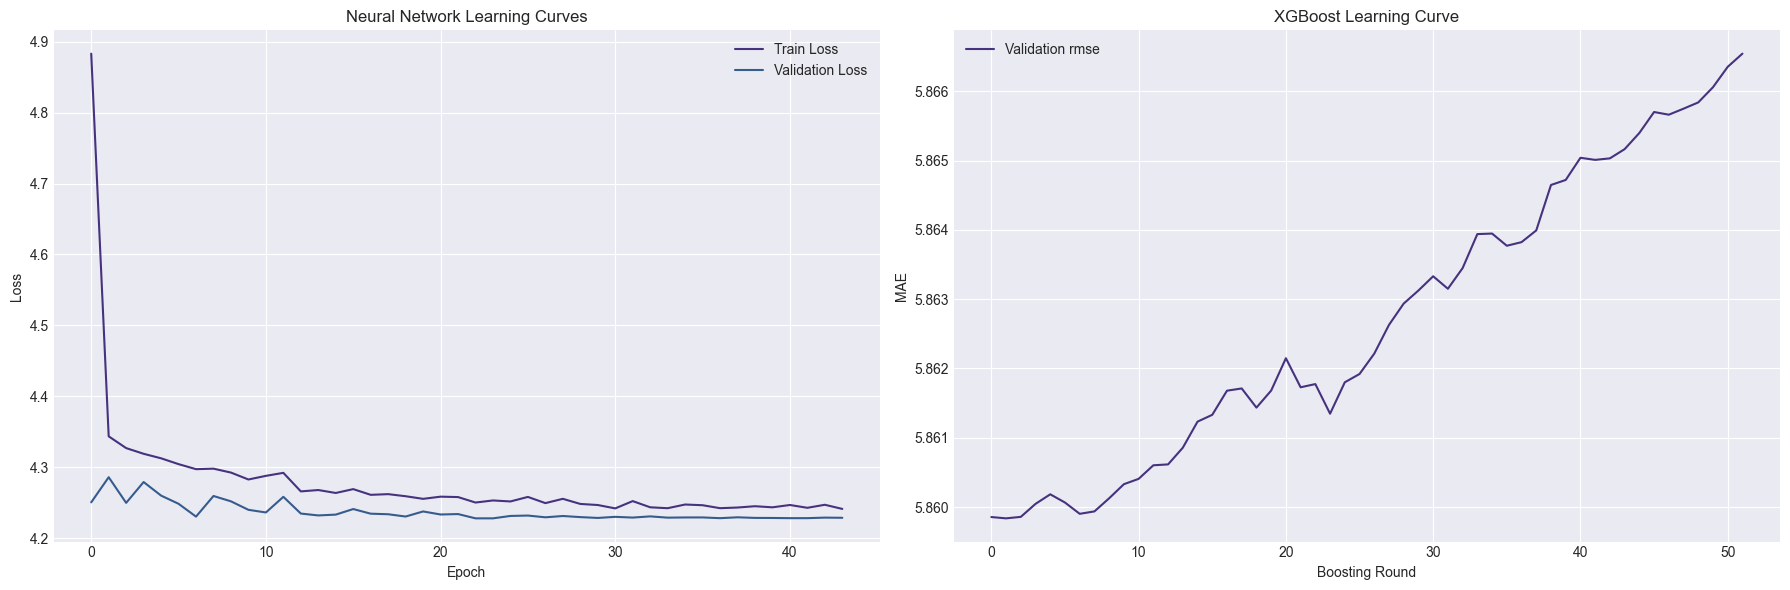

In [38]:
# %% [11] Learning Curves Analysis
def plot_learning_curves(history):
    fig, ax = plt.subplots(1, 2, figsize=(18, 6))
    
    # Neural Network Learning Curves
    ax[0].plot(history.history['loss'], label='Train Loss')
    ax[0].plot(history.history['val_loss'], label='Validation Loss')
    ax[0].set_title('Neural Network Learning Curves')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].legend()
    
    # XGBoost Learning Curve
    results = best_xgb.evals_result()
    ax[1].plot(results['validation_0']['rmse'], label='Validation rmse')
    ax[1].set_title('XGBoost Learning Curve')
    ax[1].set_ylabel('MAE')
    ax[1].set_xlabel('Boosting Round')
    ax[1].legend()
    
    plt.tight_layout()
    plt.show()

plot_learning_curves(history)